In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cat-and-dog:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F23777%2F30378%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240613%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240613T134118Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D258e90c601c64aded0cf91a1636651bc990987a22e9b908cf753a5fc79da762576f0c41c46662d17258fe61e562c720bfacdfff79f203e36bc032291a671f65282aa296bb5ad2d2725f15291f848a7481a386f6e4146f128643f6e4f37c7be441cc560340d07319be6bb3bfb977ef427ae5a80361c157f89dd93a236b63a6d97ec5da4c6614780e338ed44067dd2c6d683e891c103b3542c642bf85c2763ab9c68bcc8bdbbc1da4f742a2b500c97b6b8a50fd8978a4c5b8650af31bbeef5b25ccfb3ddff1a89ef4dd3c514f2f5e81c0d159d67da1df031ab218f0f13d40a818e2b883a756642777c1d86f4a715e5f5374dba50c741a523fdf4fef4971284f2b3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 228487605 bytes downloaded
Downloaded and uncompressed: cat-and-dog
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os

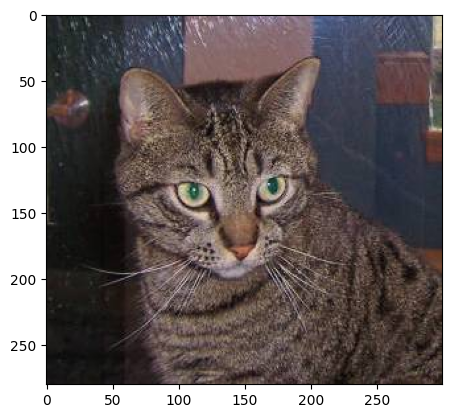

In [ ]:
img = cv2.imread("/kaggle/input/cat-and-dog/training_set/training_set/cats/cat.1.jpg")
# print(img)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [3]:
# Image resizing
def image_preprocessing(img_path, target_size=(150,150)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, target_size)
    img = img.astype('float32')/255.0
    return img

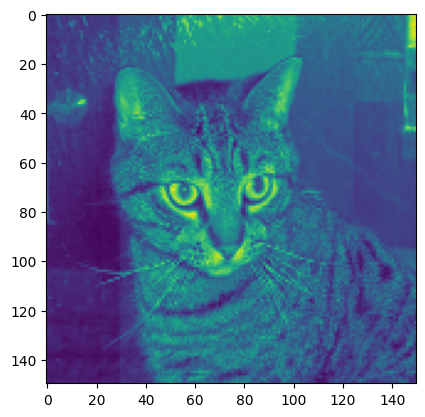

In [4]:
# Tesing the pre-processing function
img_path = "/kaggle/input/cat-and-dog/training_set/training_set/cats/cat.1.jpg"
img = image_preprocessing(img_path)
plt.imshow(img)
plt.show()

In [5]:
# Loading images
def load_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            img_path = os.path.join(directory, filename)
            img = image_preprocessing(img_path)
            images.append(img)
            labels.append(label)
    return images, labels

In [6]:
train_cats_dir = "/kaggle/input/cat-and-dog/training_set/training_set/cats/"
train_dogs_dir = "/kaggle/input/cat-and-dog/training_set/training_set/dogs/"
test_cats_dir = "/kaggle/input/cat-and-dog/test_set/test_set/cats/"
test_dogs_dir = "/kaggle/input/cat-and-dog/test_set/test_set/dogs/"

In [7]:
train_cat_images, train_cat_labels = load_images(train_cats_dir, label = 0)
train_dog_images, train_dog_labels = load_images(train_dogs_dir, label = 1)
test_cat_images, test_cat_labels = load_images(test_cats_dir, label = 0)
test_dog_images, test_dog_labels = load_images(test_dogs_dir, label = 1)


In [8]:
x_train = np.array(train_cat_images + train_dog_images)
y_train = np.array(train_cat_labels + train_dog_labels)
x_test = np.array(test_cat_images + test_dog_images)
y_test = np.array(test_cat_labels + test_dog_labels)


In [9]:
shuffle_index = np.random.permutation(len(x_train))
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_test, y_test))


Epoch 1/10
251/251 [==============================] - 14s 32ms/step - loss: 0.6859 - accuracy: 0.5618 - val_loss: 0.6602 - val_accuracy: 0.6125
Epoch 2/10
251/251 [==============================] - 7s 28ms/step - loss: 0.6166 - accuracy: 0.6623 - val_loss: 0.5924 - val_accuracy: 0.6861
Epoch 3/10
251/251 [==============================] - 7s 27ms/step - loss: 0.5136 - accuracy: 0.7438 - val_loss: 0.5115 - val_accuracy: 0.7459
Epoch 4/10
251/251 [==============================] - 8s 30ms/step - loss: 0.4064 - accuracy: 0.8117 - val_loss: 0.5156 - val_accuracy: 0.7533
Epoch 5/10
251/251 [==============================] - 7s 26ms/step - loss: 0.2912 - accuracy: 0.8768 - val_loss: 0.5564 - val_accuracy: 0.7553
Epoch 6/10
251/251 [==============================] - 7s 27ms/step - loss: 0.1507 - accuracy: 0.9418 - val_loss: 0.7673 - val_accuracy: 0.7593
Epoch 7/10
251/251 [==============================] - 7s 27ms/step - loss: 0.0598 - accuracy: 0.9785 - val_loss: 1.0756 - val_accuracy: 0.728

In [23]:
Image = "/content/dog4.jpeg"
Image = image_preprocessing(Image)
prediction = model.predict(np.expand_dims(Image, axis=0))
predicted_label = "dog" if prediction[0][0] > 0.5 else "cat"
print(f"The model predicts this image is a {predicted_label}.")


1/1 [==============================] - 0s 17ms/step
The model predicts this image is a dog.
